# Sample Solution: Project 2.1 Climate Stripes

In this exercise, you will reproduce the famous [climate stripe cover from the Economist](https://www.economist.com/leaders/2019/09/19/the-climate-issue).

### Step 1: Get climate data from ECAD

*done*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Step 2: Read the data into a DataFrame

Reading the ECAD data into pandas is a bit trickier than a standard CSV file.
You will need to inspect the file in a text editor (not Excel).
Pay attention to the following:

* what is the column separator?
* are there any headers?
* how many lines contain comments before the real data starts?

Look up the parameters of `pd.read_csv()`. They are sufficient to read the file.

In [2]:
df = pd.read_csv('TG_STAID000041.txt', skiprows=19)
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


### Step 3: Data Wrangling

The **TG** column contains the temperature measured in 0.1 Celsius degrees.
This was probably established decades ago when disk space and memory were more expensive (integers take less space).

* Create a new column by dividing the temperature by 10.
* Plot the raw temperature data as a line plot.

In [3]:
# remove spaces from column names
df.columns = [col.strip() for col in df.columns]

<AxesSubplot:>

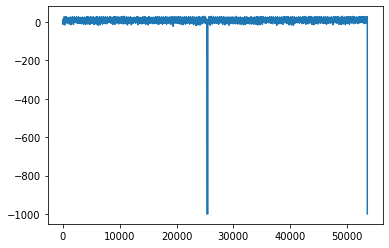

In [4]:
df['temp'] = df['TG'] / 10
df['temp'].plot()

### Step 4: Time Axis

The `DATE` column contains timestamps in the `YYYYMMDD` format.
You need to convert these to pandas timestamps.

In [5]:
date = df['DATE'].astype(str)
year = date.str[:4]
month = date.str[4:6]
day = date.str[6:]

new_date = year + '-' + month + '-' + day

df.set_index(pd.to_datetime(new_date), inplace=True)
df.head()

,SOUID,DATE,TG,Q_TG,temp
DATE,,,,,
1876-01-01,127488,18760101,22,0,2.2
1876-01-02,127488,18760102,25,0,2.5
1876-01-03,127488,18760103,3,0,0.3
1876-01-04,127488,18760104,-58,0,-5.8
1876-01-05,127488,18760105,-98,0,-9.8


<AxesSubplot:xlabel='DATE'>

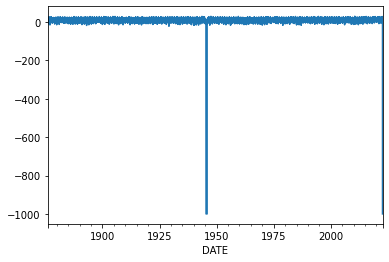

In [6]:
# plot the temperature as a line plot again.
df['temp'].plot()

### Step 5: Missing Values

For some cities, the data may contain missing values.
In the original files the value `-9999` is used.
This can be done with the `replace()` method:

In [7]:
# remove missing data entirely
# so it is not included in median calculation.
# also makes filling easier
df['temp'].replace(-999.9, np.NaN, inplace=True)

In [8]:
# method 1: apply median
median = df['temp'].median()
df['temp_filled_median'] = df['temp'].fillna(median)

<AxesSubplot:>

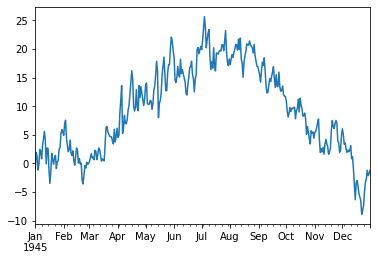

In [9]:
# method 2: average same day from year before + after
before = df.loc['1944-01-01':'1944-12-31', 'temp'].copy()  # copy before dropping stuff
index = df.loc['1944-02-29'].name
before.drop(index, axis=0, inplace=True)  # it's a leap year!
before = before.values

after =  df.loc['1946-01-01':'1946-12-31', 'temp'].values

mean = (before + after) / 2
mean = pd.Series(mean, index=pd.date_range('1945-01-01', '1945-12-31'))
mean.plot()  # the data used to patch up 1945

In [10]:
df['temp_filled_adjacent'] = df['temp'].fillna(mean)

<AxesSubplot:xlabel='DATE'>

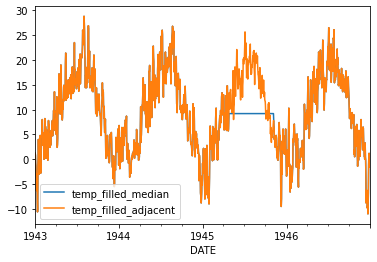

In [11]:
df.loc['1943':'1946', ['temp_filled_median', 'temp_filled_adjacent']].plot()

### Step 6: Cut off the last year

Before calculating median temperatures, make sure the last year is complete as well.
It can be cut off by slicing the index with a simple date string.
Pandas takes care of the parsing:

<AxesSubplot:xlabel='DATE'>

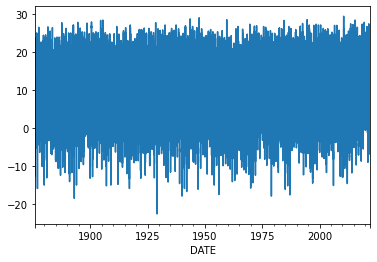

In [12]:
temp = df.loc[:'2021-12-31', 'temp_filled_adjacent']
temp.plot()

### Step 7: Aggregate

Now reduce the data to one value per year using the median.

<AxesSubplot:xlabel='DATE'>

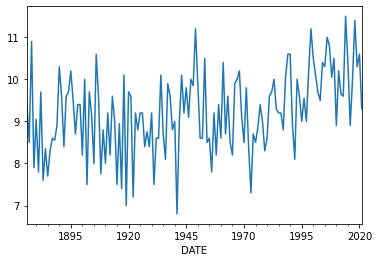

In [13]:
yearly = temp.resample('Y').median()
yearly.plot()

### Step 7: Heatmap

The `seaborn` library has a heatmap function that you can use to plot the stripes.

In [14]:
yearly_df = pd.DataFrame(yearly)
yearly_df.index = yearly_df.index.year

<AxesSubplot:title={'center':'yearly median temperature in Berlin-Dahlem'}, xlabel='DATE'>

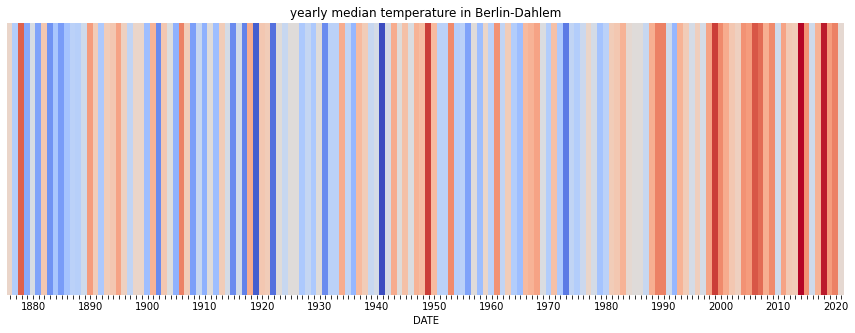

In [15]:
cmap = plt.get_cmap('coolwarm')

xlabels = [x if x % 10 == 0 else '' for x in yearly_df.index]

plt.figure(figsize=(15, 5))
plt.title('yearly median temperature in Berlin-Dahlem')
sns.heatmap(yearly_df.T, cmap=cmap, cbar=False, yticklabels=[], xticklabels=xlabels)

### Bonus: Smoothing

Before the resampling, you may average over a 5-year window (rolling mean):

<AxesSubplot:xlabel='DATE'>

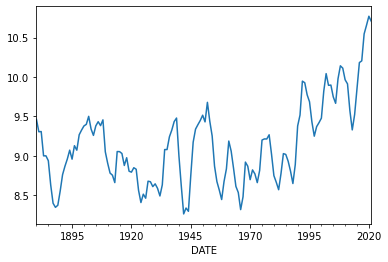

In [16]:
yearly = temp.rolling(window=5 * 365).mean().dropna()
yearly = yearly.resample('Y').median()
yearly.plot()

In [17]:
yearly_df = pd.DataFrame(yearly)
yearly_df.index = yearly_df.index.year
yearly_df

,temp_filled_adjacent
DATE,
1880,9.461425
1881,9.304603
1882,9.307397
1883,8.998904
1884,8.998959
...,...
2017,10.205096
2018,10.546849
2019,10.656548


<AxesSubplot:title={'center':'median of rolling mean temperature in Berlin-Dahlem'}, xlabel='DATE'>

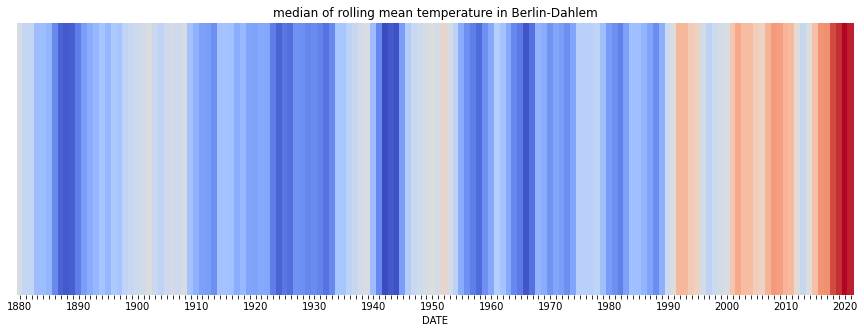

In [18]:
cmap = plt.get_cmap('coolwarm')

xlabels = [x if x % 10 == 0 else '' for x in yearly_df.index]

plt.figure(figsize=(15, 5))
plt.title('median of rolling mean temperature in Berlin-Dahlem')
sns.heatmap(yearly_df.T, cmap=cmap, cbar=False, yticklabels=[], xticklabels=xlabels)